In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('echo_ps_matches_all_notes07Feb18.csv')
texts = df.groupby('ICUSTAY_ID')['TEXT'].apply(lambda x: x.sum()).to_frame()

In [8]:
# df_match = pd.read_csv('PSMatchDetails.csv')
# len(set(df_match['icustay_id']))

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(analyzer='char_wb', ngram_range=(2,2), min_df = 0)
# cv = CountVectorizer(analyzer='char_wb', ngram_range=(3,3), min_df = 0)

In [11]:
bigrams = cv.fit_transform(texts['TEXT'])

In [13]:
import numpy as np
np.savetxt('bigrams.csv',bigrams.toarray(),delimiter=',')
# np.savetxt('trigrams.csv',trigrams.toarray(),delimiter=',')

In [34]:
df_sub = df.loc[:,['ICUSTAY_ID','PROPENSITY.SCORE','ECHO']].groupby('ICUSTAY_ID').mean()

In [43]:
bigram_df = pd.DataFrame(data=bigrams.toarray())

In [46]:
df_sub.reset_index(drop=True, inplace=True)
texts.reset_index(drop=True, inplace=True)
bigram_df.reset_index(drop=True, inplace=True)
out = pd.concat([df_sub,texts,bigram_df],axis=1)

In [48]:
# out.to_csv('master_bigram.csv')

In [49]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

In [62]:
LR.fit(out.loc[:,[i for i in range(bigrams.shape[1])]], out['ECHO'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
out['TEXT.PROPENSITY.SCORE'] = LR.predict_proba(out.loc[:,[i for i in range(bigrams.shape[1])]])[:,1]

In [70]:
out.loc[:,['ECHO','PROPENSITY.SCORE','TEXT.PROPENSITY.SCORE']]

,ECHO,PROPENSITY.SCORE,TEXT.PROPENSITY.SCORE
0,1,0.512780,0.425413
1,1,0.768120,0.414199
2,1,0.483118,0.658376
3,0,0.596660,0.440875
4,1,0.666952,0.831680
5,0,0.515942,0.006778
6,1,0.773341,0.713861
7,0,0.437484,0.167780
8,0,0.604153,0.507339
9,1,0.268699,0.917705


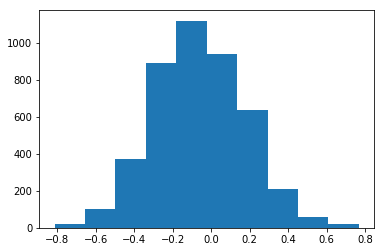

In [80]:
diff = out['PROPENSITY.SCORE']-out['TEXT.PROPENSITY.SCORE']
import matplotlib.pyplot as plt
plt.hist(diff)
plt.show()


In [82]:
np.max(out['TEXT.PROPENSITY.SCORE'])

1.0

# Ranking

In [4]:
# load bigrams
bigrams=np.loadtxt('bigrams.csv',delimiter=',')

In [5]:
# group by ICUSTAY_ID
df_sub = df.loc[:,['ICUSTAY_ID','MATCH.ID','ECHO']].groupby('ICUSTAY_ID').mean()

In [6]:
# get row nums for treatment and control
treat_ids = np.where(df_sub['ECHO']==1)[0]
control_ids = np.where(df_sub['ECHO']==0)[0]

# get the actual IDs for treatment and control
treat_ids_org = np.array(df_sub.index[df_sub['ECHO']==1].tolist())
control_ids_org = np.array(df_sub.index[df_sub['ECHO']==0].tolist())

In [7]:
# calc pairwise cos similarity between treat and control
from sklearn.metrics.pairwise import cosine_similarity
cosines = cosine_similarity(bigrams[treat_ids],bigrams[control_ids])

In [10]:
# convert matched IDs to row ID's
def find_el(el):
    res = np.where(df_sub.index.values==el)
    if len(res[0]) == 0:
        return None
    return res[0][0]
f = np.vectorize(find_el)
matched_ids=f(df_sub['MATCH.ID'])

In [11]:
# get matched ID for each treatment
treat_matches = df_sub.iloc[treat_ids]['MATCH.ID']
treat_pairs = np.vstack([treat_matches.index.values,np.array(treat_matches.tolist())]).T

In [24]:
# only select treatments that were matched
non_na_treat_pairs = treat_pairs[~np.isnan(treat_pairs).any(axis=1)].astype(int)

In [29]:
# convert each pair to row IDs
res = []
def find_rowID(row):
    where_treat = np.where(row[0]==treat_ids_org)
    where_control = np.where(row[1]==control_ids_org)
    if len(where_treat[0]) and len(where_control[0]):
        res.append([where_treat[0][0],where_control[0][0]])
np.apply_along_axis(find_rowID, 1, non_na_treat_pairs)
res = np.array(res)

In [31]:
# get all cosine similarities for each treatment
all_treat_cosines = cosines[res[:,0]]
all_treat_cosines = np.sort(all_treat_cosines.flatten())
# get matched cosines
matched_treat_cosines = cosines[res[:,0],res[:,1]]

In [40]:
rows_list = []
for row_ID, row in zip(res[:,0],all_treat_cosines):
    for col_ID, cosine in enumerate(row):
        rows_list.append([row_ID,col_ID,cosine])


In [42]:
cos_df = pd.DataFrame(rows_list)
cos_df.columns = columns=['row_ID','col_ID','cosine']

In [50]:
cos_df = cos_df.sort_values('cosine',ascending=0).reset_index()

In [69]:
res[0]

array([   5, 1387])

In [72]:
cos_df.index[(cos_df['row_ID'] == 5) & (cos_df['col_ID'] == 1387)].tolist()

[40263]

In [178]:
# get row/col pairs that are in the extremes
top_text_top_org = []
bottom_text_top_org = []

def get_rank(pair):
    row, col = pair
    rank = cos_df.index[(cos_df['row_ID'] == row) & (cos_df['col_ID'] == col)].tolist()[0]
    print(rank)
    if rank < 50000:
        top_text_top_org.append([row,col])
    if rank > cos_df.shape[0] - 50000:
        top_text_bottom_org.append([row,col])
np.apply_along_axis(get_rank, 1, res)

top_text_top_org = np.array(top_text_top_org)
top_text_bottom_org = np.array(top_text_bottom_org)

40263
940300
276518
1588248
895252
929479
835291
1491993
119959
706888
992816
1072183
351535
1031966
1170433
915098
174297
1305974
1073043
999450
48453
1465008
1380692
956634
1010095
962137
107887
358429
561678
1254993
1191043
1309090
854985
168733
179074
304663
131296
1413861
204627
1377446
478593
620221
934804
382719
278729
1219334
276638
1363698
147205
1069574
820942
1387604
1048917
131991
553369
1063852
1490751
582313
1026944
1653791


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [172]:
top_text_top_org.shape

(32, 2)

In [176]:
control=df_sub[df_sub['ECHO']==1].iloc[top_text_top_org[:,0]].index.values
treat=df_sub[df_sub['ECHO']==0].iloc[top_text_top_org[:,1]].index.values
top_top_texts = np.vstack([texts.loc[control]['TEXT'].values.astype(str),texts.loc[treat]['TEXT'].values])
df_out = pd.DataFrame(top_top_texts.T).replace("\\", "").replace('\n',' ', regex=True).replace('\r',' ', regex=True).replace("\"", "").replace("\'", "")
df_out[0] = df_out[0].astype(str).str[:4000]
df_out[1] = df_out[1].astype(str).str[:1000]

df_out.to_csv('top-top.csv',index=None)

In [177]:
control=df_sub[df_sub['ECHO']==1].iloc[bottom_text_top_org[:,0]].index.values
treat=df_sub[df_sub['ECHO']==0].iloc[bottom_text_top_org[:,1]].index.values
top_top_texts = np.vstack([texts.loc[control]['TEXT'].values.astype(str),texts.loc[treat]['TEXT'].values])
df_out = pd.DataFrame(top_top_texts.T).replace("\\", "").replace('\n',' ', regex=True).replace('\r',' ', regex=True).replace("\"", "").replace("\'", "")
df_out[0] = df_out[0].astype(str).str[:4000]
df_out[1] = df_out[1].astype(str).str[:4000]

df_out.to_csv('top-bottom.csv',index=None)

NameError: name 'bottom_text_top_org' is not defined

In [16]:
rankings = np.searchsorted(, -cosines[res[:,0],res[:,1]])

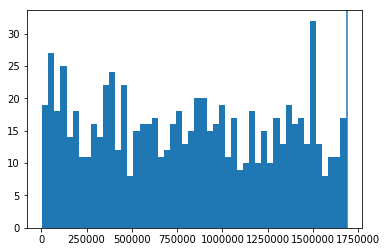

In [17]:
import matplotlib.pyplot as plt
plt.hist(rankings.astype(int),bins=50)
plt.axvline(x=787*2143)
plt.show()

In [18]:
rankings

array([  40263,  940300,  276518, 1588248,  895252,  929479,  835291,
       1491993,  119959,  706888,  992816, 1072183,  351535, 1031966,
       1170433,  915098,  174297, 1305974, 1073043,  999450,   48453,
       1465008, 1380692,  956634, 1010095,  962137,  107887,  358429,
        561678, 1254993, 1191043, 1309090,  854985,  168733,  179074,
        304663,  131296, 1413861,  204627, 1377446,  478593,  620221,
        934804,  382719,  278729, 1219334,  276638, 1363698,  147205,
       1069574,  820942, 1387604, 1048917,  131991,  553369, 1063852,
       1490751,  582313, 1026944, 1653791, 1161266, 1239350, 1186846,
        747576,  236873, 1155608, 1020540, 1234005,  526005, 1121790,
         97912, 1106565,   66596,  713819,  628470,  864496,  460756,
        928439, 1198908,  696970, 1425207, 1019683,  999245, 1132591,
        316226, 1306746, 1063301,  171371,  632792, 1681162, 1336120,
        474455, 1434820,  783533, 1442132,  695677, 1419198, 1381657,
        321537, 1510

In [192]:
# convert matched IDs to row ID's
def find_el(el):
    res = np.where(df_sub.index.values==el)
    if len(res[0]) == 0:
        return None
    return res[0][0]
f = np.vectorize(find_el)
matched_ids=f(df_sub['MATCH.ID'])

In [193]:
# for each treatment row ID, find where the matched ID is in terms of the pairwise cos sim over control ID's
positions = []
for i,treat_id in enumerate(treat_ids):
    ranking = ranking_treat_control[i]
    id_to_find = matched_ids[treat_id]
    if id_to_find:
        id = np.where(ranking == id_to_find)[0]
        if id:
            positions.append(id[0])
    else:
        positions.append(None)
positions = np.array(positions)

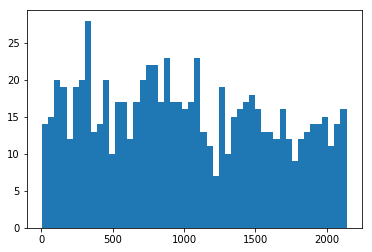

In [199]:
import matplotlib.pyplot as plt
data=positions[positions!=None]
plt.hist(data.astype(int),bins=50)
plt.show()

In [200]:
np.sum(positions!=None)

787